In [1]:
from scipy.io import loadmat
import tempfile
import glob
import re
import h5py
from ScanImageTiffReader import ScanImageTiffReader
from scipy.ndimage import uniform_filter1d
from scipy.ndimage import binary_dilation
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from tenacity import retry, stop_after_attempt, wait_fixed

In [2]:
import numpy as np
from scipy.ndimage import uniform_filter1d
from scipy.stats import linregress

def smooth_exp(D, mode, window):
    """
    Smooth data but do a linear fit at the start to avoid issues with edge
    effects. Useful for exponential bleaching curves.
    """
    # First dimension is time
    origsz = D.shape
    D = D.reshape(D.shape[0], -1)
    window = int(min(window, D.shape[0]))  # Ensure window is an integer
    t = np.arange(1, window + 1)
    p = np.column_stack((t, np.ones_like(t)))

    # Smooth data
    if mode == 'movmean':
        sVals = uniform_filter1d(D, size=window, axis=0, mode='nearest')
    else:
        raise ValueError("Unsupported mode")

    lVals = np.full((len(t), D.shape[1]), np.nan)
    for ix in range(D.shape[1]):
        inds = np.where(~np.isnan(D[t-1, ix]))[0]
        if len(inds) > 0:
            b = linregress(inds, D[inds, ix])
            lVals[:, ix] = p @ np.array([b.slope, b.intercept])

    weights = t / len(t)
    sVals[t-1, :] = weights[:, None] * sVals[t-1, :] + (1 - weights[:, None]) * lVals

    mVals = uniform_filter1d(D[:min(len(D), 2*window), :] - sVals[:min(len(D), 2*window), :], size=window, axis=0, mode='nearest')
    sVals[:window, :] = sVals[:window, :] + mVals[:window, :]
    sVals = sVals.reshape(origsz)
    
    return sVals


In [3]:
import numpy as np
import scipy.ndimage as ndimage
from skimage.filters import difference_of_gaussians
import matplotlib.pyplot as plt
from skimage.morphology import square

def localize_flashes_bergamo(IM, aData, params, doPlot=False):
    # Inputs:
    # IM:        3D recording, X x Y x Time
    # aData:     alignment metadata
    tau = params['tau_s'] / (params['frametime'] * params['dsFac'])  # time constant in frames
    params['tau_frames'] = tau
    sigma = params['sigma_px']  # space constant in pixels

    denoiseWindow = params['denoiseWindow_samps']
    baselineWindow = int(np.ceil(params['baselineWindow_Glu_s'] / (params['frametime'] * params['dsFac'])))

    nans = np.isnan(IM)
    IMavg = np.nanmean(IM, axis=2)
    IMgamma = np.sqrt(np.maximum(0, IMavg))

    BG = np.percentile(IMavg[~np.isnan(IMavg)], 10)

    # Subtract background, relevant for Bergamo only (not SLAP2)
    IMf = IM - BG
    IMf[nans] = 0

    # Apply Difference of Gaussians filter
    IMf = difference_of_gaussians(IMf, sigma, 5 * sigma)
    IMf = IMf - np.mean(IMf)

    # Apply spatial filter
    IMf = ndimage.convolve(IMf, np.ones((1, 1, 1)), mode='constant', cval=0.0)
    IMstruct = ndimage.convolve(np.maximum(0, IMavg), np.ones((1, 1)), mode='constant', cval=0.0)  # filtered structural image, used for decorrelating motion

    # Highpass filter in time
    IMf[nans] = np.nan
    IMf = IMf - ndimage.median_filter(IMf, size=(1, 1, baselineWindow))
    nans = np.isnan(IMf)

    # Remove motion-associated variance
    IMf = decorrelate_motion(IMf, IMstruct, aData, params)

    # Normalize by expected poisson noise
    IMavg_nans = np.isnan(IMavg)
    Pnoise = np.maximum(IMavg, 0)  # squared poisson noise
    Mnoise = np.sqrt(
        ndimage.convolve(Pnoise - np.roll(Pnoise, 1, axis=0), np.ones((1, 1)), mode='constant', cval=0.0) ** 2 +
        ndimage.convolve(Pnoise - np.roll(Pnoise, -1, axis=0), np.ones((1, 1)), mode='constant', cval=0.0) ** 2 +
        ndimage.convolve(Pnoise - np.roll(Pnoise, 1, axis=1), np.ones((1, 1)), mode='constant', cval=0.0) ** 2 +
        ndimage.convolve(Pnoise - np.roll(Pnoise, -1, axis=1), np.ones((1, 1)), mode='constant', cval=0.0) ** 2
    )

    IMnoise = np.sqrt(ndimage.convolve(Pnoise, np.abs(np.ones((1, 1))), mode='constant', cval=0.0))
    IMnoise = IMnoise + np.percentile(IMnoise[~IMavg_nans], 33) + 0.2 * np.sqrt(Mnoise)
    IMnoise[IMavg_nans] = np.nan

    # Add an extra dimension to IMnoise to match the shape of IMf
    IMnoise = IMnoise[:, :, np.newaxis]

    IMf = IMf / IMnoise

    # Temporal matched filter
    IMf[nans] = 0
    mem = IMf[:, :, -1]
    gamma = np.exp(-1 / tau)
    for t in range(IMf.shape[2] - 1, -1, -1):
        IMf[:, :, t] = np.maximum(0, gamma * mem) + (1 - gamma) * IMf[:, :, t]
        mem = IMf[:, :, t]
    IMf[nans] = np.nan

    # Compute a summary image based on skewness
    summary = np.nanmean(IMf ** 3, axis=2)
    summary = ndimage.grey_dilation(summary, size=(5, 5))  # remove noisy edges

    P = get_tiled_peaks(IMf, IMavg, summary)

    # Plot a figure
    if doPlot:
        plot_summary(summary, IMgamma, P)

    return summary, P, params

# def plot_summary(summary, IMgamma, P):
#     red = summary / np.percentile(summary[~np.isnan(summary)], 99)
#     cyan = IMgamma / np.percentile(IMgamma[~np.isnan(IMgamma)], 99)
#     plt.imshow(np.dstack((red, cyan, cyan)))
#     plt.scatter(P['col'], P['row'], s=100 * (P['val'] / np.mean(P['val'])) ** 2, c='m')
#     plt.show()

def plot_summary(summary, IMgamma, P):
    red = summary / np.percentile(summary[~np.isnan(summary)], 99)
    cyan = IMgamma / np.percentile(IMgamma[~np.isnan(IMgamma)], 99)
    
    # Clip the values to the range [0, 1]
    red = np.clip(red, 0, 1)
    cyan = np.clip(cyan, 0, 1)
    
    # Stack the channels and display the image
    rgb_image = np.dstack((red, cyan, cyan))
    plt.imshow(rgb_image)
    plt.scatter(P['col'], P['row'], s=10 * (P['val'] / np.mean(P['val'])) ** 2, edgecolors='m', facecolors='none')
    plt.show()

def get_tiled_peaks(IM, IMavg, summary):
    valid = ~ndimage.grey_dilation(np.isnan(IM), size=(5, 5, 1))
    peaks = valid
    for dim in range(3):
        peaks = peaks & (IM > np.roll(IM, 1, axis=dim)) & (IM > np.roll(IM, -1, axis=dim))

    linInds = np.where(peaks)
    vvv = IM[linInds]
    rrr, ccc, ttt = linInds

    sz = IM.shape
    tilesize = 64
    tilestartsR = np.arange(1, sz[0] - tilesize // 4, tilesize // 2)
    tileendsR = np.minimum(sz[0], tilestartsR + tilesize - 1)
    tilestartsC = np.arange(1, sz[1] - tilesize // 4, tilesize // 2)
    tileendsC = np.minimum(sz[1], tilestartsC + tilesize - 1)

    summaryVals = summary[rrr, ccc]

    keep = np.zeros(len(ttt), dtype=bool)  # which events to keep
    vNorm = np.zeros(len(ttt))  # the event sizes, Z-scored

    for rix in range(len(tilestartsR)):
        for cix in range(len(tilestartsC)):
            selStats = (rrr >= tilestartsR[max(0, rix - 1)]) & (rrr <= tileendsR[min(len(tileendsR) - 1, rix + 1)]) & \
                       (ccc >= tilestartsC[max(0, cix - 1)]) & (ccc <= tileendsC[min(len(tileendsC) - 1, cix + 1)])

            S = summary[tilestartsR[max(0, rix - 1)]:tileendsR[min(len(tileendsR) - 1, rix + 1)],
                        tilestartsC[max(0, cix - 1)]:tileendsC[min(len(tileendsC) - 1, cix + 1)]]
            Sp = np.percentile(S, [1, 33])
            Sthresh = Sp[1] + 5 * (Sp[1] - Sp[0])
            selS = summaryVals > Sthresh

            vals = vvv[selStats & selS]
            ptile = np.percentile(vals, [1, 50])
            vals = 3 * (vals - ptile[1]) / (ptile[1] - ptile[0])
            thresh = ptile[1] + 2 * (ptile[1] - ptile[0])  # threshold is 2*[98% confint], corresponding to an SNR of ~6
            selTile = (rrr >= tilestartsR[rix]) & (rrr <= tileendsR[rix]) & \
                      (ccc >= tilestartsC[cix]) & (ccc <= tileendsC[cix]) & \
                      (vvv > thresh) & selS  # the events within this tile that should be kept
            keep[selTile] = True
            vNorm[selStats & selS] = np.maximum(vNorm[selStats & selS], vals)

    rrr = rrr[keep]
    ccc = ccc[keep]
    ttt = ttt[keep]
    vvv = vNorm[keep]

    # Upsample for superresolution
    pC = []
    pR = []
    for peakIx in range(len(ttt) - 1, -1, -1):
        R = IM[rrr[peakIx] + np.array([-1, 0, 1]), ccc[peakIx], ttt[peakIx]]
        C = IM[rrr[peakIx], ccc[peakIx] + np.array([-1, 0, 1]), ttt[peakIx]]

        ratioR = min(1e6, (R[1] - R[0]) / (R[1] - R[2]))
        dR = (1 - ratioR) / (1 + ratioR) / 2
        pR.append(rrr[peakIx] - dR)

        ratioC = min(1e6, (C[1] - C[0]) / (C[1] - C[2]))
        dC = (1 - ratioC) / (1 + ratioC) / 2
        pC.append(ccc[peakIx] - dC)

    P = {'row': pR, 'col': pC, 't': ttt, 'val': vvv}
    return P

def decorrelate_motion(IM, IMavg, aData, params):
    nanFrames = np.all(np.isnan(IM), axis=(0, 1))
    IMnan = np.isnan(IM)
    sz = IM.shape
    nPCs = 20
    goodPixels = np.mean(~IMnan, axis=2) > 0.9
    goodPixels = goodPixels.flatten()  # Ensure goodPixels is 1-dimensional
    IM2 = IM.copy()
    IM2[IMnan] = 0
    IM2 = IM2.reshape(sz[0] * sz[1], -1)
    IM2 = IM2 - np.mean(IM2, axis=1, keepdims=True)
    imageGrads = np.stack([IMavg - np.roll(IMavg, 1, axis=0), IMavg - np.roll(IMavg, 1, axis=1),
                           IMavg - np.roll(IMavg, -1, axis=0), IMavg - np.roll(IMavg, -1, axis=1)], axis=2)
    imageGrads = imageGrads.reshape(sz[0] * sz[1], -1)
    U, S, Vt = np.linalg.svd(IM2[goodPixels, :], full_matrices=False)
    b = np.linalg.lstsq(imageGrads[goodPixels, :], U, rcond=None)[0]
    correction = (imageGrads @ b) @ np.diag(S) @ Vt
    IM[:, :, ~nanFrames] = IM[:, :, ~nanFrames] - correction.reshape(sz[0], sz[1], -1)
    return IM

In [4]:
import numpy as np
from scipy.ndimage import shift, binary_dilation
from scipy.ndimage import generate_binary_structure
from scipy.interpolate import griddata
import cv2

def xcorr2_nans(frame, template, shiftsCenter, dShift):
    """
    Perform a somewhat-efficient local normalized cross-correlation for images with NaNs.
    
    Parameters:
    - frame: the frame to be aligned; this has more NaNs
    - template: the template
    - shiftsCenter: the center offset around which to perform a local search
    - dShift: the maximum shift (scalar, in pixels) to consider on each axis around shiftsCenter
    
    Returns:
    - motion: the calculated motion vector
    - R: the correlation coefficient
    """
    SE = np.ones((2 * dShift + 1, 2 * dShift + 1), dtype=np.bool_)
    # Create structuring element for dilation
    # SE = generate_binary_structure(dShift, 1)
    # SE = binary_dilation(SE, iterations=dShift)
    
    # Valid pixels of the new frame
    fValid = ~np.isnan(frame) & shift(~binary_dilation(np.isnan(template), structure=SE), shiftsCenter)
    fValid[:dShift, :] = False
    fValid[-dShift:, :] = False
    fValid[:, :dShift] = False
    fValid[:, -dShift:] = False

    # shiftsCenter = np.array(shiftsCenter) 
    tValid = np.roll(fValid, shift=-np.array(shiftsCenter))

    F = frame[fValid]  # fixed data
    ssF = np.sqrt(np.sum(F**2))

    # Correlation is sum(A.*B)./(sqrt(ssA)*sqrt(ssB)); ssB is constant though
    shifts = np.arange(-dShift, dShift + 1)
    C = np.full((len(shifts), len(shifts)), np.nan)
    for drix in range(len(shifts)):
        for dcix in range(len(shifts)):
            T = template[np.roll(tValid, (-shifts[drix], shifts[dcix]), axis=(0, 1))]
            ssT = np.sum(T**2)
            C[drix, dcix] = np.sum(F * T) / np.sqrt(ssT)
                
    # Find maximum of correlation map
    maxval = np.nanmax(C)
    if np.isnan(maxval):
        raise ValueError("All-NaN slice encountered in cross-correlation.")
    
    rr, cc = np.unravel_index(np.nanargmax(C), C.shape)

    R = maxval / ssF  # correlation coefficient

    if 1 < rr < len(shifts) - 1 and 1 < cc < len(shifts) - 1:
        # Perform superresolution upsampling
        ratioR = min(1e6, (C[rr, cc] - C[rr - 1, cc]) / (C[rr, cc] - C[rr + 1, cc]))
        dR = (1 - ratioR) / (1 + ratioR) / 2

        ratioC = min(1e6, (C[rr, cc] - C[rr, cc - 1]) / (C[rr, cc] - C[rr, cc + 1]))
        dC = (1 - ratioC) / (1 + ratioC) / 2

        motion = shiftsCenter + np.array([shifts[rr] - dR, shifts[cc] - dC])
    else:
        # The optimum is at an edge of search range; no superresolution
        motion = shiftsCenter + np.array([shifts[rr], shifts[cc]])

    if np.any(np.isnan(motion)):
        raise ValueError("NaN encountered in motion calculation.")

    return motion, R


def make_template_multi_roi(Y, maxshift):
    sz = Y.shape
    R = np.ones((sz[2], sz[2]))
    motion = np.zeros((2, sz[2], sz[2]))

    for f1 in range(sz[2]):
        for f2 in range(f1 + 1, sz[2]):
            m1, _ = xcorr2_nans(Y[:, :, f2], Y[:, :, f1], [0, 0], maxshift)
            motion[:, f1, f2], R[f1, f2] = xcorr2_nans(Y[:, :, f2], Y[:, :, f1], np.round(m1).astype(int), maxshift)
            motion[:, f2, f1] = -motion[:, f1, f2]
            R[f2, f1] = R[f1, f2]

    bestR = np.max(np.median(R, axis=0))
    maxind = np.argmax(np.median(R, axis=0))
    frameInds = np.where(R[:, maxind] >= bestR)[0]

    # Create view matrices for interpolation
    viewR, viewC = np.meshgrid(np.arange(1, sz[0] + 2 * maxshift + 1) - maxshift,
                               np.arange(1, sz[1] + 2 * maxshift + 1) - maxshift,
                               indexing='ij')
    
    template = np.full((2 * maxshift + sz[0], 2 * maxshift + sz[1], len(frameInds)), np.nan)
   
    for i, fix in enumerate(frameInds):
        M = Y[:, :, fix]
        # Xq, Yq = np.meshgrid(np.arange(sz[1]), np.arange(sz[0]))
        Xq = (viewC - motion[1, fix, maxind]).astype(np.float32)
        Yq = (viewR - motion[0, fix, maxind]).astype(np.float32)
        template[:, :, i] = cv2.remap(M, Xq, Yq, cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=np.nan)

    template = np.nanmean(template, axis=2)
    # template[np.sum(np.isnan(template), axis=2) > np.floor(template.shape[2] / 2)] = np.nan

    return template

In [5]:
def interp2(x, y, z, xi, yi):
    # This function performs 2D interpolation similar to MATLAB's interp2
    coords = np.array([yi, xi])
    return map_coordinates(z, coords, order=1, mode='constant', cval=np.nan)

In [6]:
# Define the retry decorator
@retry(stop=stop_after_attempt(4), wait=wait_fixed(3))
def read_tiff_file(fn):
    print('Reading:', fn)
    A = ScanImageTiffReader(fn)
    Ad = np.array(A.data(), dtype=np.float32).T
    return Ad

Temporary file created at: /tmp/tmp6m2m4bim.h5
Reading: /root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-Delete/79/SIMULATION_scan_00004_79_Trial5_DOWNSAMPLED-2x.tif
Trial: 8
Reading: /root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-Delete/79/SIMULATION_scan_00004_79_Trial4_DOWNSAMPLED-2x.tif


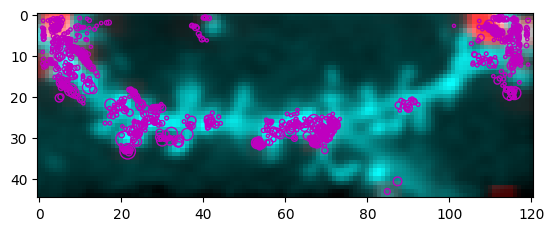

Trial: 7
Reading: /root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-Delete/79/SIMULATION_scan_00004_79_Trial8_DOWNSAMPLED-2x.tif


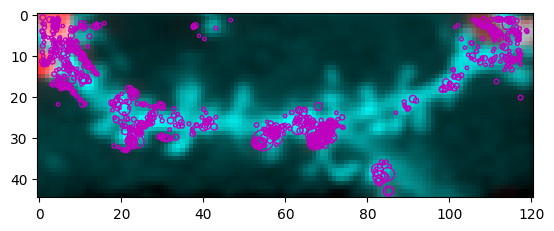

Trial: 6
Reading: /root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-Delete/79/SIMULATION_scan_00004_79_Trial2_DOWNSAMPLED-2x.tif


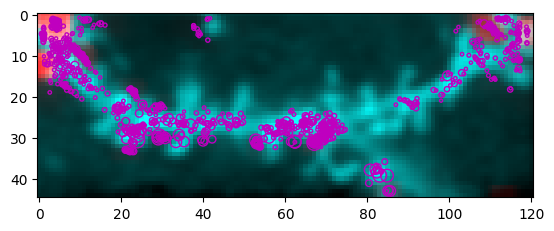

Trial: 5
Reading: /root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-Delete/79/SIMULATION_scan_00004_79_Trial6_DOWNSAMPLED-2x.tif


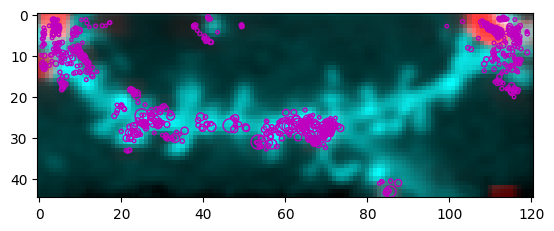

Trial: 4
Reading: /root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-Delete/79/SIMULATION_scan_00004_79_Trial3_DOWNSAMPLED-2x.tif


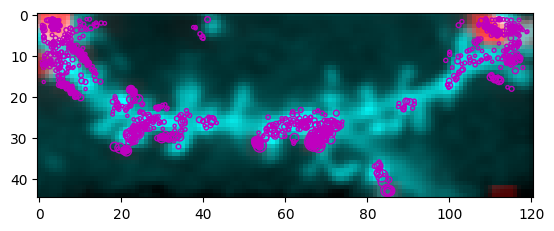

Trial: 3
Reading: /root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-Delete/79/SIMULATION_scan_00004_79_Trial7_DOWNSAMPLED-2x.tif


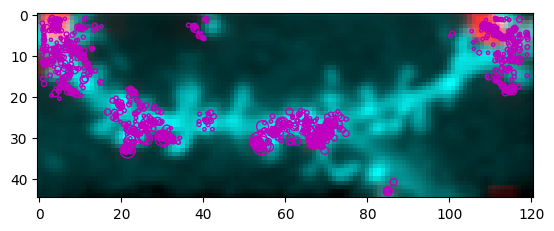

Trial: 2
Reading: /root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-Delete/79/SIMULATION_scan_00004_79_Trial1_DOWNSAMPLED-2x.tif


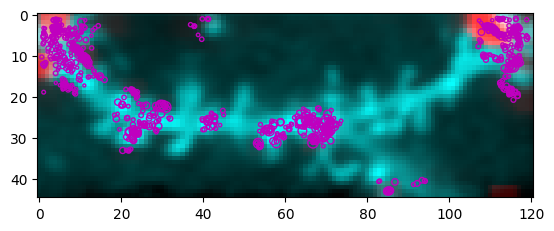

Trial: 1
Reading: /root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-Delete/79/SIMULATION_scan_00004_79_Trial9_DOWNSAMPLED-2x.tif


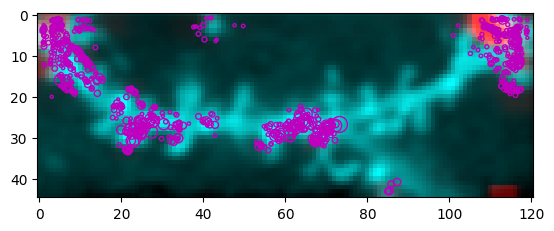

Trial: 0
Reading: /root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-Delete/79/SIMULATION_scan_00004_79_Trial5_DOWNSAMPLED-2x.tif


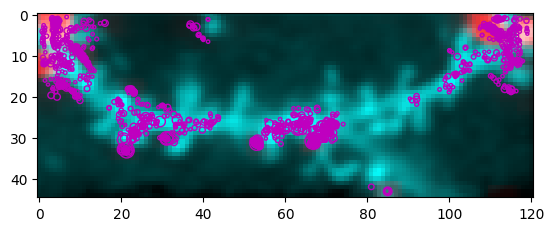

In [7]:
import os
import glob
import re
import tempfile
import h5py
import numpy as np
from ScanImageTiffReader import ScanImageTiffReader

savedr = '/root/capsule/scratch/test1/'

# Define the directory path
fns = '/root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-Delete/79/'

# Define the pattern to match files
pattern = os.path.join(fns, '*_Trial*_DOWNSAMPLED-2x.tif')

# Use glob to find all files matching the initial pattern
initial_matching_files = glob.glob(pattern)

# Define a regular expression to match files ending with 'Trial<int>.tif'
regex = re.compile(r'.*_Trial\d+_DOWNSAMPLED-2x.tif$')

# Filter the files using the regular expression
strict_matching_files = [f for f in initial_matching_files if regex.match(f)]

params = {
    "tau_s": 0.027,  # time constant in seconds for glutamate channel; from Aggarwal et al 2023 Fig 5
    "sigma_px": 1.33,  # space constant in pixels
    "eventRateThresh_hz": 1/10,  # minimum event rate in Hz
    "sparseFac": 0.1,  # sparsity factor for shrinking sources in space, 0-1, higher value makes things sparser
    "nmfIter": 5,  # number of iterations of NMF refinement
    "dXY": 3,  # how large sources can be (radius), pixels
    "upsample": 1,  # how many times to upsample the imaging resolution for finding local maxima to identify sources; affects maximum source density
    "nmfBackgroundComps": 0,  # <=4, max number of background components to use for NMF. If 0, we compute F0 instead of fitting background
    "denoiseWindow_samps": 35,  # number of samples to average together for denoising
    "baselineWindow_Glu_s": 2,  # timescale for calculating F0 in glutamate channel, seconds
    "baselineWindow_Ca_s": 2  # timescale for calculating F0 in calcium channel, seconds
}

# Path to the original HDF5 file
original_gt_path = '/root/capsule/data/iGluSnFR-testing-Sim-Data-Registered-Delete/79/SIMULATION_scan_00004_79_Trial1_ALIGNMENTDATA.h5'

# Create a temporary file for the HDF5 operations
with tempfile.NamedTemporaryFile(suffix='.h5', delete=False) as temp_file:
    temp_file_path = temp_file.name

# Copy contents from the original HDF5 file to the temporary file
with h5py.File(original_gt_path, 'r') as original_gt, h5py.File(temp_file_path, 'w') as temp_gt:
    for key in original_gt.keys():
        original_gt.copy(key, temp_gt)

trialIx = 0

print(f"Temporary file created at: {temp_file_path}")

# Process the TIFF files
discardFrames = [None] * len(strict_matching_files)
rawIMs = [None] * len(strict_matching_files)
peaks = [None] * len(strict_matching_files)

# Read the first file to get the shape
first_fn = strict_matching_files[0]
first_IM = read_tiff_file(first_fn)

# Initialize meanIM
meanIM = np.full((first_IM.shape[0], first_IM.shape[1], 1, len(strict_matching_files)), np.nan)
actIM = []
for trialIx in range(len(strict_matching_files)-1, -1, -1):
    print('Trial:', trialIx)
    fn = strict_matching_files[trialIx]

    # Load the TIFF
    IM = read_tiff_file(fn)
    
    if IM.shape[1] < 100:
        raise ValueError(f'{fn} is very short')
    
    IM = IM.reshape(IM.shape[0], IM.shape[1], 1, -1)  # deinterleave
    
    meanIM[:, :, :, trialIx] = np.nanmean(IM, axis=3)

    # Load alignment data from the temporary file
    with h5py.File(temp_file_path, 'r+') as temp_gt:
        # Check if the dataset 'aData/dsFac' exists, create it if not
        if 'aData/dsFac' in temp_gt:
            dsFac_dset = temp_gt['aData/dsFac']
        else:
            dsFac_dset = temp_gt.create_dataset('aData/dsFac', data=round(len(temp_gt['aData/motionC'][()]) / len(temp_gt['aData/motionDSc'][()])))

        params['dsFac'] = dsFac_dset[()]
        params['frametime'] = temp_gt['aData/frametime'][()]
        numChannels = temp_gt['aData/numChannels'][()]

        # Flatten aRankCorr
        aRankCorr_flat = np.ravel(temp_gt['aData/aRankCorr'])

        # Calculate the window size for the moving median
        window_size = int(np.ceil(10 / (temp_gt['aData/frametime'][()] * temp_gt['aData/dsFac'][()])))

        # Calculate the moving median using uniform_filter1d
        moving_median = uniform_filter1d(aRankCorr_flat, size=window_size)

        # Subtract the moving median from aRankCorr
        tmp = aRankCorr_flat - moving_median
        
        filtTmp = smooth_exp(tmp, 'movmean', np.ceil(.2/((temp_gt['aData/frametime'][()]*temp_gt['aData/dsFac'][()]))))

        # Assuming trialIx and filtTmp are defined
        discardFrames[trialIx] = binary_dilation(filtTmp < -(4 * np.std(filtTmp)), structure=np.ones(5))

        # Assuming trialIx, IM, and discardFrames are defined
        rawIMs[trialIx] = np.squeeze(IM[:,:,0,:])
        rawIMs[trialIx][:,:,discardFrames[trialIx]] = np.nan

        if numChannels == 2:
            rawIM2s[trialIx] = np.squeeze(IM[:,:,1,:])
            rawIM2s[trialIx][:,:,discardFrames[trialIx]] = np.nan
        
        IMc, peaks[trialIx], params = localize_flashes_bergamo(rawIMs[trialIx], temp_gt, params, True)

        # calculate correlation image
       # Initialize a numpy array with the desired shape and fill it with np.nan
        actIM_trial = np.full((IM.shape[0], IM.shape[1], 1), np.nan)

        # Assign values to slices of actIM_trial
        actIM_trial[IMc.shape[0]:, :, :] = np.nan
        actIM_trial[:, IMc.shape[1]:, :] = np.nan
        actIM_trial[:IMc.shape[0], :IMc.shape[1], 0] = IMc

        # Append actIM_trial to actIM
        actIM.append(actIM_trial)

        params['sz'] = meanIM.shape[:2]
        
        temp_gt.close()
    # break

In [18]:
actIM = np.stack(actIM, axis=-1)

maxshift = 12
M = np.nansum(meanIM, axis=2)
template = make_template_multi_roi(M, maxshift)

print('Aligning across trials...')

Mpad = np.full((template.shape[0], template.shape[1], M.shape[2]), np.nan)
Mpad[maxshift:maxshift+M.shape[0], maxshift:maxshift+M.shape[1], :] = M

Aligning across trials...


/tmp/ipykernel_22394/1651224310.py:106: RuntimeWarning: Mean of empty slice
  template = np.nanmean(template, axis=2)


trial: 9


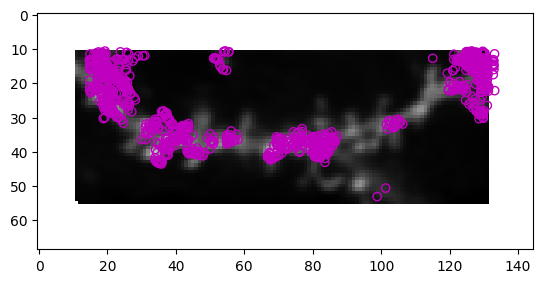

trial: 8


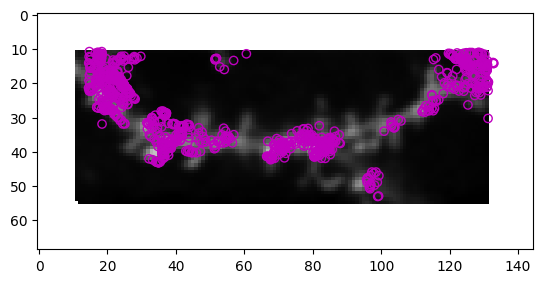

trial: 7


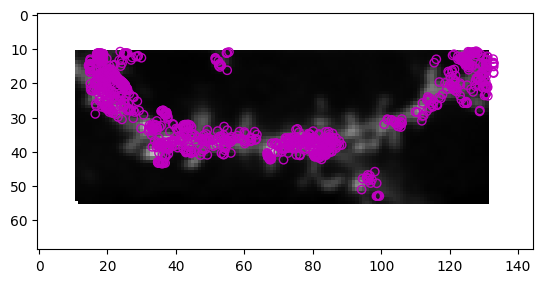

trial: 6


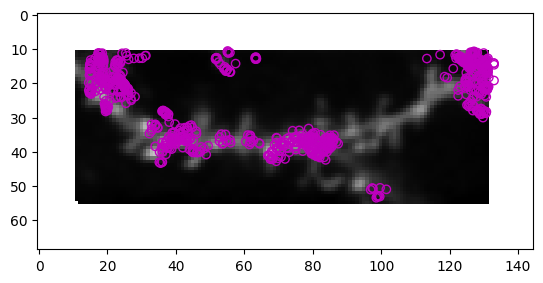

trial: 5


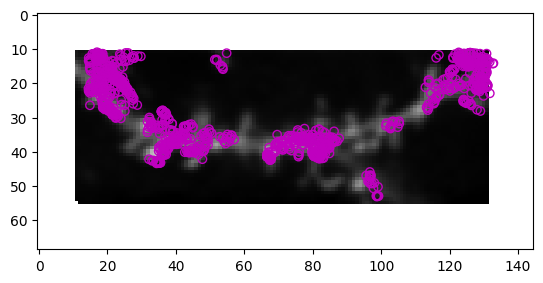

trial: 4


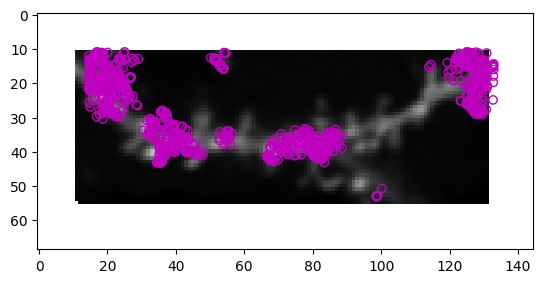

trial: 3


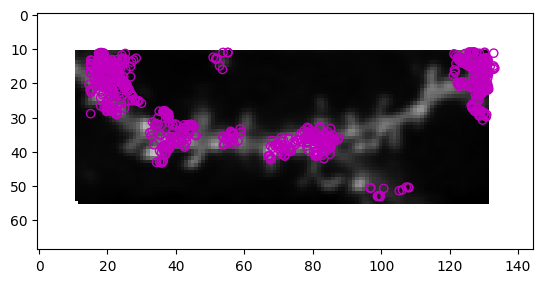

trial: 2


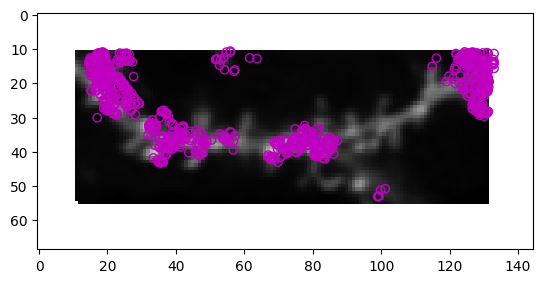

trial: 1


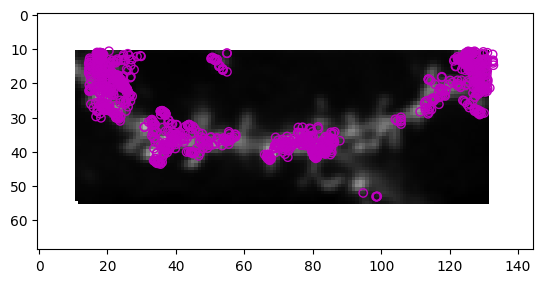

In [41]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Assuming fns, Mpad, template, maxshift, meanIM, actIM, peaks, rawIMs are defined

motOutput = np.zeros((2, len(strict_matching_files)))
corrCoeff = np.zeros(len(strict_matching_files))
meanAligned = np.zeros_like(meanIM)
actAligned = np.zeros_like(actIM)
peaksCat = {'row': [], 'col': [], 'val': [], 't': []}

for trialIx in range(len(strict_matching_files)-1, -1, -1):
    print(f'trial: {trialIx + 1}')
    
    mot1, _ = xcorr2_nans(Mpad[:, :, trialIx], template, [0, 0], maxshift)
    motOutput[:, trialIx], corrCoeff[trialIx] = xcorr2_nans(Mpad[:, :, trialIx], template, np.round(mot1).astype(int), maxshift)
    
    rr, cc = np.meshgrid(np.arange(meanIM.shape[0]), np.arange(meanIM.shape[1]), indexing='ij')
    
    for chIx in range(meanIM.shape[2]):
        map_x = cc + motOutput[1, trialIx]
        map_y = rr + motOutput[0, trialIx]
        
        meanAligned[:, :, chIx, trialIx] = cv2.remap(meanIM[:, :, chIx, trialIx], map_x.astype(np.float32), map_y.astype(np.float32), interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=np.nan)
        actAligned[:, :, chIx, trialIx] = cv2.remap(actIM[:, :, chIx, trialIx], map_x.astype(np.float32), map_y.astype(np.float32), interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=np.nan)
    
    if trialIx == len(strict_matching_files) - 1:
        peaksCat['row'] = peaks[trialIx]['row'] - motOutput[0, trialIx]
        peaksCat['col'] = peaks[trialIx]['col'] - motOutput[1, trialIx]
        peaksCat['val'] = peaks[trialIx]['val']
        peaksCat['t'] = peaks[trialIx]['t']
        plt.figure()
        plt.imshow(template, cmap='gray')
        plt.scatter(maxshift + np.array(peaks[trialIx]['col']) - motOutput[1, trialIx], maxshift + np.array(peaks[trialIx]['row']) - motOutput[0, trialIx], edgecolors='m', facecolors='none')
        plt.show()
    else:
        peaksCat['row'] = np.concatenate((peaks[trialIx]['row'] - motOutput[0, trialIx], peaksCat['row']))
        peaksCat['col'] = np.concatenate((peaks[trialIx]['col'] - motOutput[1, trialIx], peaksCat['col']))
        peaksCat['val'] = np.concatenate((peaks[trialIx]['val'], peaksCat['val']))
        peaksCat['t'] = peaksCat['t'] + rawIMs[trialIx].shape[2]
        peaksCat['t'] = np.concatenate((peaks[trialIx]['t'], peaksCat['t']))
        plt.figure()
        plt.imshow(template, cmap='gray')
        plt.scatter(maxshift + np.array(peaks[trialIx]['col']) - motOutput[1, trialIx], maxshift + np.array(peaks[trialIx]['row']) - motOutput[0, trialIx], edgecolors='m', facecolors='none')
        plt.show()


In [44]:
# identify outliers in alignment quality. Evalauting the error of alignment of each trial to the global trial template. 
cc = corrCoeff

if 'forceCorrThresh' in locals() and forceCorrThresh > 0:
    corrThresh = forceCorrThresh
else:
    corrThresh = min(0.96, np.median(cc) - 2 * np.std(cc))

validTrials = np.where(cc > corrThresh)

exptSummary = {}
exptSummary['meanIM'] = np.nanmean(meanAligned, axis=3)
exptSummary['actIM'] = np.nanmean(actAligned, axis=3)

/tmp/ipykernel_22394/1870846271.py:11: RuntimeWarning: Mean of empty slice
  exptSummary['meanIM'] = np.nanmean(meanAligned, axis=3)
/tmp/ipykernel_22394/1870846271.py:12: RuntimeWarning: Mean of empty slice
  exptSummary['actIM'] = np.nanmean(actAligned, axis=3)


In [146]:
import numpy as np
import scipy.stats as stats
import scipy.ndimage as ndimage
from skimage.restoration import richardson_lucy
import cv2
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max

def clusterLocalizations(peaks, params):
    sz = params['sz']  # XY size of the summary image
    upsample = params['upsample']
    ampThresh = np.min(peaks['val'])
    nEventsTotal = len(peaks['val'])
    kernelSigma = 1 / upsample
    rGrid = np.linspace(1, sz[0], upsample * sz[0] + 1)
    cGrid = np.linspace(1, sz[1], upsample * sz[1] + 1)
    rr, cc = np.meshgrid(rGrid, cGrid, indexing='ij')
    density = np.zeros_like(rr)

    for eIx in range(nEventsTotal):
        rMin = peaks['row'][eIx] - (8 * kernelSigma)
        rMax = peaks['row'][eIx] + (8 * kernelSigma)
        cMin = peaks['col'][eIx] - (8 * kernelSigma)
        cMax = peaks['col'][eIx] + (8 * kernelSigma)
        rSel = (rGrid > rMin) & (rGrid < rMax)
        cSel = (cGrid > cMin) & (cGrid < cMax)

        rLoc = rr[rSel][:, cSel]
        cLoc = cc[rSel][:, cSel]
        A = stats.multivariate_normal.pdf(np.column_stack([rLoc.ravel(), cLoc.ravel()]), mean=[peaks['row'][eIx], peaks['col'][eIx]], cov=kernelSigma * np.eye(2))
        A = (peaks['val'][eIx] / np.max(A)) * A

        density[rSel][:, cSel] += A.reshape(rLoc.shape)

    # Deconvolution
    deconvSigma = np.sqrt(2) * upsample * params['sigma_px'] / np.sqrt(ampThresh)
    filtSize = 2 * np.ceil(3 * deconvSigma).astype(int) + 1
    
    selRows = ndimage.binary_dilation(np.any(density, axis=1, keepdims=True), structure=np.ones((filtSize, 1))).flatten()
    selCols = ndimage.binary_dilation(np.any(density, axis=0, keepdims=True), structure=np.ones((1, filtSize))).flatten()
    PSF = cv2.getGaussianKernel(filtSize, deconvSigma) * cv2.getGaussianKernel(filtSize, deconvSigma).T
    IMest = density.copy()
    # IMest[selRows, :][:, selCols] = cv2.filter2D(density[selRows, :][:, selCols], -1, PSF)
    IMest[np.ix_(selRows, selCols)] = richardson_lucy(density[np.ix_(selRows, selCols)], PSF, num_iter=20)

    # Find regional maxima
    # Convert IMest to a numpy array if it's not already
    IMest = np.array(IMest)

    # Find local maxima
    coordinates = peak_local_max(IMest, min_distance=5)

    # Create a boolean image with the same shape as IMest
    BW = np.zeros_like(IMest, dtype=bool)

    # Set the pixels at the coordinates of the local maxima to True
    BW[tuple(coordinates.T)] = True
    print(np.sum(BW))
    BW = BW & (IMest > np.mean(IMest[IMest > 0]))

    
    
    maxR, maxC = np.where(BW)
    V = IMest[BW]
    sortorder = np.argsort(V)[::-1]  # 'descend' equivalent in Python
    maxR = maxR[sortorder]
    maxC = maxC[sortorder]

    print(maxR.shape, maxC.shape)

    # Compute pairwise distances to cull spurious maxima
    keep = np.ones(len(V), dtype=bool)
    dMaxima = squareform(pdist(np.column_stack([maxR, maxC])))
    np.fill_diagonal(dMaxima, np.inf)
    
    for vIx in range(len(V)):
        if not np.isnan(dMaxima[vIx, vIx]):
            sel = dMaxima[vIx, :] < upsample
            dMaxima[sel, :] = np.nan
            dMaxima[:, sel] = np.nan
            keep[sel] = False

    maxR = maxR[keep]
    maxC = maxC[keep]
    V = V[keep]
    k = len(V)
    sourceR = rGrid[maxR]
    sourceC = cGrid[maxC]

    # Perform assignment using k-means-like approach
    weights = np.ones(k)
    assignments = np.zeros(nEventsTotal, dtype=int)
    done = False
    ksigma = (upsample * params['sigma_px'] / np.sqrt(2 * ampThresh))
    while not done:
        zScore = np.sqrt((sourceR[:, None] - peaks['row'])**2 + (sourceC[:, None] - peaks['col'])**2) / ksigma
        zScore[zScore > 2] = np.inf
        likelihoods = stats.norm.pdf(zScore) * weights[:, None]
        maxVal = np.max(likelihoods, axis=0)
        maxInds = np.argmax(likelihoods, axis=0)
        maxInds[maxVal == 0] = 0  # unassigned points

        if np.array_equal(maxInds, assignments):
            done = True
            keepEvents = np.min(zScore, axis=0) < 2
            keepSources = np.zeros(k, dtype=bool)
            for ix in range(k):
                keepSources[ix] = np.sum(assignments == ix) >= params['minEvents']
                keepEvents[assignments == ix] = keepSources[ix]
            peaks['row'] = peaks['row'][keepEvents]
            peaks['col'] = peaks['col'][keepEvents]
            peaks['val'] = peaks['val'][keepEvents]
            peaks['t'] = peaks['t'][keepEvents]

            sourceR = sourceR[keepSources]
            sourceC = sourceC[keepSources]
            weights = weights[keepSources]
            k = np.sum(keepSources)

            zScore = np.sqrt((sourceR[:, None] - peaks['row'])**2 + (sourceC[:, None] - peaks['col'])**2) / ksigma
            zScore[zScore > 2] = np.inf
            likelihoods = stats.norm.pdf(zScore) * weights[:, None]
            assignments = np.argmax(likelihoods, axis=0)

            assignProbs = likelihoods / np.sum(likelihoods, axis=0)
        else:
            assignments = maxInds
            for ii in range(k):
                sel = maxInds == ii
                sourceR[ii] = np.mean(peaks['row'][sel])
                sourceC[ii] = np.mean(peaks['col'][sel])
                weights[ii] = np.sqrt(np.sum(sel))

    peaks['assignments'] = assignments
    peaks['assignProbs'] = assignProbs

    # Plot event assignments to sources
    plt.figure('Event assignments to sources')
    plt.imshow(density, extent=(cGrid.min(), cGrid.max(), rGrid.min(), rGrid.max()), origin='lower', cmap='gray')
    colors = plt.cm.hsv(np.linspace(0, 1, k))
    np.random.shuffle(colors)
    for sourceIx in range(k):
        sel = assignProbs[:, sourceIx] > 0.5
        plt.scatter(sourceC[sourceIx], sourceR[sourceIx], s=300, marker='x', edgecolor=colors[sourceIx], linewidth=2)
        plt.scatter(peaks['col'][sel], peaks['row'][sel], edgecolor=colors[sourceIx])
    plt.show()

    return density, peaks, sourceR, sourceC, params


In [147]:
from functools import reduce

# cluster localizations
totalFrames = sum([x.shape[2] for x in rawIMs])
params['minEvents'] = totalFrames * params['frametime'] * params['dsFac'] * params['eventRateThresh_hz']
_, P, sources['R'], sources['C'], params = clusterLocalizations(peaksCat, params)
# k = len(sources['R'])  # number of sources
# sz = params['sz']

# # Generate IMsel; the data only in the selected region, aligned across movies
# selPix = np.zeros(sz[:2], dtype=bool)

0
(0,) (0,)


ValueError: zero-size array to reduction operation maximum which has no identity